## Exploratory Data Analysis: Player Age & Performance Metrics

In this section, we will:

- Summarize the dataset structure
- Visualize the distribution of player ages
- Explore relationships between age and key performance metrics

In [3]:
from src import utils

path = "/Users/charlierobinson/Documents/Code/SheffUtd/SUFC/data/SUFC Data Scientist RB Export 2024-25 (Complete).csv"

df = utils.load_data(path)

Shape: (238, 147)
Columns: ['Name', 'Team', 'Position', 'Nationality', 'Season', '(€) Market Value', 'Contract End', 'Age', 'Height (cm)', 'Side', 'Strong foot', 'GBE', 'Games', 'Minutes', 'Yellow Cards', 'Red Cards', '% Passing', 'Passes into Final ⅓', 'Completed Long Balls', '% Long Balls', 'Successful Short Passes', 'Long Balls Received', 'Passes per Long Ball', 'Average Pass Distance', 'Passes', '% Passing Contribution', '% Open Play Passes into Opp. Box', 'Blocked Shots', 'Tackles/Was Dribbled', 'Successful Tackles', 'Interceptions', 'Clearances', 'Fouls', 'Recoveries', 'Individual Pressure', 'Aggresive Actions', 'Quick Recoveries', 'Tackles/Was Dribbled ⅔', 'Tackles Attempted', 'Defensive Actions', '% High Defensive Actions', 'Individual Pressure Opp. Half', '% Ground Duels', '% Quick Recoveries', 'Diff. Defensive Distance Team', 'Non-Penalty Goals', 'Shots', 'Shooting', 'Finishing', 'Expected Goals', 'xG per Shot', 'Header per Shot', 'Header per Cross', 'xG per NPG', 'Headers', 

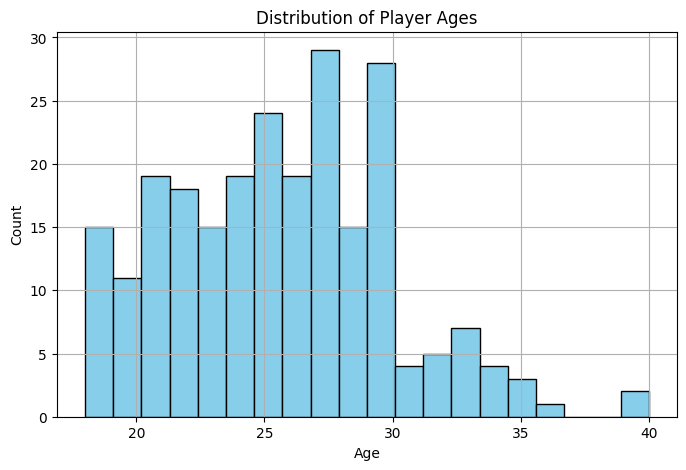

Correlation matrix:
                Age     Goals   Assists  % Passing
Age        1.000000 -0.022941  0.012253   0.139565
Goals     -0.022941  1.000000  0.460519   0.101807
Assists    0.012253  0.460519  1.000000   0.160908
% Passing  0.139565  0.101807  0.160908   1.000000


In [4]:
# 1. Quick summary of the dataset
utils.quick_summary(df)

# 2. Check missing values per column
print('Missing values per column:')
print(df.isnull().sum())

# 3. Convert relevant columns to numeric (adjust column names as needed)
numeric_cols = ['Age', 'Goals', 'Assists', 'Pass Completion %']
df = utils.to_numeric_safe(df, numeric_cols)

# 4. Visualize age distribution
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
df['Age'].hist(bins=20, ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Player Ages')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()

# 5. Correlation between age and performance metrics
utils.show_correlations(df, ['Age', 'Goals', 'Assists', '% Passing'])

## 6. Correlation Heatmap

Visualize correlations between age and performance metrics using a heatmap for easier interpretation.

In [ ]:
# Create correlation heatmap
fig = utils.plot_correlation_heatmap(df, ['Age', 'Goals', 'Assists', '% Passing'])
utils.save_fig(fig, 'outputs/correlation_heatmap.png')
plt.show()

## 7. Age vs Performance Scatter Plots

Examine the relationship between age and individual performance metrics.

In [ ]:
# Age vs Goals
fig = utils.plot_age_vs_metric(df, 'Goals')
utils.save_fig(fig, 'outputs/age_vs_goals.png')
plt.show()

In [ ]:
# Age vs Assists
fig = utils.plot_age_vs_metric(df, 'Assists')
utils.save_fig(fig, 'outputs/age_vs_assists.png')
plt.show()

In [ ]:
# Age vs Passing %
fig = utils.plot_age_vs_metric(df, '% Passing')
utils.save_fig(fig, 'outputs/age_vs_passing.png')
plt.show()

## 8. Performance by Age Groups

Compare performance metrics across different age groups.

In [ ]:
# Performance by age groups
fig = utils.plot_age_distribution_by_groups(df)
utils.save_fig(fig, 'outputs/performance_by_age_groups.png')
plt.show()

## 9. Insights and Recommendations

Generate a comprehensive report with insights and recommendations.

In [ ]:
# Generate and display insights
insights = utils.generate_correlation_insights(df, ['Age', 'Goals', 'Assists', '% Passing'])
print(insights)

## 10. Complete EDA Report

Generate a comprehensive report summarizing all findings.

In [ ]:
# Generate complete report
report = utils.generate_eda_report(
    df, 
    ['Age', 'Goals', 'Assists', '% Passing'],
    output_path='outputs/eda_report.md'
)
print(report)